In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

# ✅ GPU 장치 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ✅ 데이터 로드
data = pd.read_csv('../document/cleaned_data_without_lat_lon_outlierslinear.csv')

# ✅ created_at 변환 및 time_diff 계산
data["created_at"] = pd.to_datetime(data["created_at"])
data["time_diff"] = data["created_at"].diff().dt.total_seconds().fillna(0)

# ✅ MMSI 정보 저장 (예측 결과와 연결하기 위해 유지)
mmsi_list = data["mmsi"].values  

# ✅ 독립 변수와 타겟 변수 설정
selected_columns = ['lat', 'lon', 'turn', 'speed', 'accuracy', 'course', 'heading', 
    'wind_direct', 'wind_speed', 'surface_curr_drc', 'surface_curr_speed', 
    'avg_speed_5steps', 'avg_heading_5steps', 'position_change_5steps', 
    'avg_speed_10steps', 'avg_heading_10steps', 'position_change_10steps', 
    'avg_speed_30steps', 'avg_heading_30steps', 'position_change_30steps']  

target_columns = ["lat", "lon"]  # 타겟 변수

# ✅ 스케일링 적용 (로그 변환 전, 0 이상 보장)
scaler = MinMaxScaler(feature_range=(0.01, 1))  # 0보다 큰 범위로 조정
data[["lat", "lon"]] = scaler.fit_transform(data[["lat", "lon"]])
data[["lat", "lon"]] = np.log1p(data[["lat", "lon"]])  # 로그 변환 적용


# ✅ **과거 데이터를 학습하고, 마지막 신호에서 예측하도록 시계열 데이터 변환**
time_steps = 15  # 과거 5개 데이터를 입력으로 사용
future_steps = [5, 10, 30]  # 5분 후, 10분 후, 30분 후 예측

# ✅ 입력값 생성 (과거 5개 시점 포함)
X = np.stack([data[selected_columns].shift(i).values for i in range(time_steps, 0, -1)], axis=1)[time_steps:]

# ✅ 미래 시점 값 생성 (벡터화 연산 적용)
y = np.stack([data[target_columns].shift(-step).values for step in future_steps], axis=1)[time_steps:-max(future_steps)]

# ✅ MMSI 저장
mmsi_seq = data["mmsi"].values[time_steps:-max(future_steps)]

# ✅ NumPy 배열 변환
X, y, mmsi_seq = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(mmsi_seq)

# ✅ 결과 출력
print(f"X 크기: {X.shape}, y 크기: {y.shape}, MMSI 크기: {mmsi_seq.shape}")

# ✅ 🚀 마지막 신호(`X_last`)를 기반으로 예측할 수 있도록 생성
X_last = np.stack([data[selected_columns].shift(i).values for i in range(time_steps, 0, -1)], axis=1)[-1:]
X_last_tensor = torch.tensor(X_last, dtype=torch.float32).to(device)

# ✅ 결과 출력
print(f"X_last 크기: {X_last.shape}")



Using device: cuda
X 크기: (1662591, 15, 20), y 크기: (1662561, 3, 2), MMSI 크기: (1662561,)
X_last 크기: (1, 15, 20)


In [6]:
# ✅ MMSI 저장
X_train, y_train = X, y  # **모든 데이터를 학습에 포함**
mmsi_seq = data["mmsi"].values[time_steps:]  # ✅ 수정된 부분

# ✅ NumPy 배열 변환
X, y, mmsi_seq = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(mmsi_seq)

# ✅ 크기 출력 확인
print(f"X 크기: {X.shape}, y 크기: {y.shape}, MMSI 크기: {mmsi_seq.shape}")

# ✅ MMSI별 마지막 신호 추출을 위한 딕셔너리 생성
X_last_dict = {}
mmsi_last_dict = {}

# ✅ MMSI별 마지막 신호 추출
for mmsi in np.unique(mmsi_seq):
    mmsi_mask = mmsi_seq == mmsi
    if sum(mmsi_mask) >= 5:
        # 🔥 마지막 5개 데이터 선택
        X_selected = X[mmsi_mask][-5:]

        # 🚨 데이터 크기 확인 후 변환
        if X_selected.shape == (5, 5, 20):  
            X_selected = X_selected[:, -1, :]  # ✅ (5, 20)으로 변환

        X_last_dict[mmsi] = X_selected
        mmsi_last_dict[mmsi] = mmsi

# ✅ 모든 선박의 `X_last` 데이터를 NumPy 배열로 변환
mmsi_last_all = np.array(list(mmsi_last_dict.values()))
X_last_all = np.array(list(X_last_dict.values()))

# ✅ 최종 크기 확인
print(f"변환된 X_last_all 크기: {X_last_all.shape}")


X 크기: (1662591, 15, 20), y 크기: (1662561, 3, 2), MMSI 크기: (1662591,)
변환된 X_last_all 크기: (1225, 5, 15, 20)


In [12]:
# ✅ X_last_all 크기 확인
if len(X_last_all) == 0:
    raise ValueError("🚨 X_last_all이 비어 있습니다! MMSI별 마지막 데이터가 정상적으로 수집되지 않았는지 확인하세요.")

# ✅ 불필요한 차원이 있는 경우 제거 (예상 문제 해결)
if X_last_all.ndim == 4 and X_last_all.shape[2] == X_last_all.shape[1]:  # (1225, 5, 15, 20) → (1225, 5, 20)
    X_last_all = X_last_all[:, :, -1, :]  # 3번째 차원(15)을 제거하여 (1225, 5, 20)로 맞춤

# ✅ time_steps 크기 맞추기
required_time_steps = X_train.shape[1]  # 원하는 time_steps (15)
current_time_steps = X_last_all.shape[1]  # 현재 time_steps (5)

if current_time_steps < required_time_steps:
    pad_size = required_time_steps - current_time_steps

    # ✅ time_steps 축(1번째 차원)에만 패딩 적용
    X_last_all = np.pad(
        X_last_all, 
        ((0, 0), (0, pad_size), (0, 0)),  # ✅ time_steps 축만 확장 (1225, 5, 20) → (1225, 15, 20)
        mode='edge'
    )

elif current_time_steps > required_time_steps:
    # ✅ 최신 15개 데이터만 유지
    X_last_all = X_last_all[:, -required_time_steps:, :]

# ✅ 🚀 Tensor 변환 및 GPU 이동
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_last_tensor = torch.tensor(X_last_all, dtype=torch.float32).to(device)

# ✅ 결과 확인
print(f"✅ 변환된 X_train_tensor 크기: {X_train_tensor.shape}")
print(f"✅ 변환된 y_train_tensor 크기: {y_train_tensor.shape}")
print(f"✅ 변환된 X_last_tensor 크기: {X_last_tensor.shape}")


✅ 변환된 X_train_tensor 크기: torch.Size([1662591, 15, 20])
✅ 변환된 y_train_tensor 크기: torch.Size([1662561, 3, 2])
✅ 변환된 X_last_tensor 크기: torch.Size([1225, 15, 20])


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterSampler
import numpy as np

# ✅ LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력을 사용하여 예측
        return out.view(out.shape[0], 3, 2)  # (batch_size, 3, 2)로 변환

# ✅ 하이퍼파라미터 범위 확장
param_dist = {
    'hidden_size': [32, 64, 128, 256, 512, 1024],  # ✅ 1024 추가
    'num_layers': [1, 2, 3, 4, 5, 6],  # ✅ 5, 6 추가
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],  # ✅ 0.0005, 0.005 추가
    'batch_size': [16, 32, 64, 128, 256],  # ✅ 256 추가
    'dropout': [0.0, 0.2, 0.3, 0.4, 0.5]  # ✅ 0.3, 0.4 추가
}

# ✅ 샘플링 개수 증가
possible_combinations = np.prod([len(v) for v in param_dist.values()])
n_iter = min(500, possible_combinations)  # 기존 20 → 500으로 증가
random_params = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# ✅ 크기 불일치 문제 해결 (작은 데이터 기준으로 맞추기)
min_samples = min(len(X_train_tensor), len(y_train_tensor))
X_train_tensor = X_train_tensor[:min_samples]
y_train_tensor = y_train_tensor[:min_samples]

print(f"✅ 조정된 X_train_tensor 크기: {X_train_tensor.shape}")
print(f"✅ 조정된 y_train_tensor 크기: {y_train_tensor.shape}")

# ✅ 최적 파라미터 찾기
best_loss = float('inf')
best_params = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for params in random_params:
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    dropout = params['dropout']

    # ✅ output_size를 자동으로 설정
    output_size = y_train.shape[1] * y_train.shape[2]  # 미래 시점(3) × lat/lon(2) = 6

    # ✅ 모델 초기화
    model = LSTMModel(
        input_size=X_train.shape[2],  # feature 개수
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=output_size,  # 수정됨
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # ✅ StepLR 스케줄러 사용 (5 에포크마다 학습률 0.5배 감소)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # ✅ 배치 학습 (마지막 배치 크기 문제 해결)
    model.train()
    train_loss = 0.0
    num_batches = max(1, len(X_train_tensor) // batch_size)  # 배치 개수 계산 (최소 1 보장)

    for i in range(0, len(X_train_tensor), batch_size):
        actual_batch_size = min(batch_size, len(X_train_tensor) - i)  # ✅ 마지막 배치 크기 조정

        X_batch = X_train_tensor[i:i+actual_batch_size]
        y_batch = y_train_tensor[i:i+actual_batch_size]

        optimizer.zero_grad()
        outputs = model(X_batch)  # (batch_size, 3, 2)로 출력됨
        loss = criterion(outputs, y_batch)  # (batch_size, 3, 2)로 손실 계산
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ✅ 평균 손실 계산 (0으로 나누는 문제 방지)
    avg_loss = train_loss / num_batches

    # ✅ 학습률 스케줄러 적용
    scheduler.step()

    # ✅ 하이퍼파라미터 및 손실 출력 (깔끔한 출력 형식 적용)
    print(f"Params: Hidden={hidden_size}, Layers={num_layers}, LR={optimizer.param_groups[0]['lr']:.6f}, "
          f"Batch={batch_size}, Dropout={dropout} → Loss: {avg_loss:.4f}")

    # ✅ 최적 파라미터 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = params

print(f"✅ 최적 파라미터: {best_params}, 손실: {best_loss:.4f}")


✅ 조정된 X_train_tensor 크기: torch.Size([1662561, 15, 20])
✅ 조정된 y_train_tensor 크기: torch.Size([1662561, 3, 2])
Params: Hidden=1024, Layers=2, LR=0.001000, Batch=64, Dropout=0.3 → Loss: 0.0025
Params: Hidden=128, Layers=3, LR=0.010000, Batch=256, Dropout=0.0 → Loss: 0.0041
Params: Hidden=256, Layers=5, LR=0.000100, Batch=128, Dropout=0.2 → Loss: 0.0031
Params: Hidden=256, Layers=5, LR=0.005000, Batch=128, Dropout=0.2 → Loss: 0.0039


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Params: Hidden=256, Layers=1, LR=0.005000, Batch=16, Dropout=0.3 → Loss: 0.0013


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: Hidden=512, Layers=1, LR=0.000100, Batch=64, Dropout=0.5 → Loss: 0.0016
Params: Hidden=256, Layers=2, LR=0.005000, Batch=64, Dropout=0.0 → Loss: 0.0028
Params: Hidden=1024, Layers=2, LR=0.000100, Batch=16, Dropout=0.0 → Loss: 0.0013
Params: Hidden=256, Layers=2, LR=0.010000, Batch=256, Dropout=0.2 → Loss: 0.0060
Params: Hidden=64, Layers=1, LR=0.005000, Batch=256, Dropout=0.0 → Loss: 0.0026
Params: Hidden=64, Layers=3, LR=0.010000, Batch=16, Dropout=0.3 → Loss: 0.0012
Params: Hidden=512, Layers=6, LR=0.005000, Batch=64, Dropout=0.3 → Loss: 0.0035
Params: Hidden=1024, Layers=1, LR=0.000100, Batch=128, Dropout=0.5 → Loss: 0.0021
Params: Hidden=32, Layers=6, LR=0.000500, Batch=32, Dropout=0.4 → Loss: 0.0024


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Params: Hidden=64, Layers=1, LR=0.001000, Batch=32, Dropout=0.4 → Loss: 0.0011
Params: Hidden=512, Layers=4, LR=0.005000, Batch=256, Dropout=0.0 → Loss: 0.0132
Params: Hidden=512, Layers=3, LR=0.005000, Batch=16, Dropout=0.4 → Loss: 0.0017
Params: Hidden=128, Layers=6, LR=0.010000, Batch=256, Dropout=0.3 → Loss: 0.0049
Params: Hidden=64, Layers=3, LR=0.000100, Batch=128, Dropout=0.0 → Loss: 0.0026
Params: Hidden=128, Layers=5, LR=0.000100, Batch=64, Dropout=0.0 → Loss: 0.0026
Params: Hidden=512, Layers=3, LR=0.000500, Batch=64, Dropout=0.4 → Loss: 0.0026
Params: Hidden=1024, Layers=6, LR=0.005000, Batch=64, Dropout=0.0 → Loss: 0.0060
Params: Hidden=64, Layers=6, LR=0.010000, Batch=128, Dropout=0.4 → Loss: 0.0031
Params: Hidden=256, Layers=6, LR=0.005000, Batch=256, Dropout=0.0 → Loss: 0.0046
Params: Hidden=512, Layers=2, LR=0.000500, Batch=256, Dropout=0.3 → Loss: 0.0031


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Params: Hidden=64, Layers=1, LR=0.005000, Batch=32, Dropout=0.2 → Loss: 0.0019
Params: Hidden=1024, Layers=5, LR=0.001000, Batch=32, Dropout=0.4 → Loss: 0.0023
Params: Hidden=1024, Layers=5, LR=0.010000, Batch=32, Dropout=0.3 → Loss: 0.0093
Params: Hidden=128, Layers=2, LR=0.000500, Batch=128, Dropout=0.5 → Loss: 0.0025
Params: Hidden=1024, Layers=3, LR=0.010000, Batch=16, Dropout=0.5 → Loss: 0.0073
Params: Hidden=128, Layers=1, LR=0.000100, Batch=256, Dropout=0.3 → Loss: 0.0036
Params: Hidden=256, Layers=2, LR=0.005000, Batch=128, Dropout=0.3 → Loss: 0.0030
Params: Hidden=256, Layers=4, LR=0.005000, Batch=16, Dropout=0.3 → Loss: 0.0013
Params: Hidden=256, Layers=1, LR=0.000100, Batch=256, Dropout=0.5 → Loss: 0.0029
Params: Hidden=512, Layers=5, LR=0.000500, Batch=256, Dropout=0.4 → Loss: 0.0037
Params: Hidden=64, Layers=4, LR=0.000100, Batch=256, Dropout=0.0 → Loss: 0.0049
Params: Hidden=1024, Layers=1, LR=0.001000, Batch=32, Dropout=0.4 → Loss: 0.0013
Params: Hidden=128, Layers=2, LR

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

best_params = {'num_layers': 1, 'learning_rate': 0.0005, 'hidden_size': 256, 'dropout': 0.0, 'batch_size': 16}
# ✅ output_size 자동 설정 (3개 미래 시점 × lat/lon)
output_size = y_train.shape[1] * y_train.shape[2]  # 3 * 2 = 6

# ✅ LSTM 모델 정의 (출력 차원 자동 조정)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 출력: (batch_size, time_steps, hidden_size)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝 사용
        return out.view(out.shape[0], 3, 2)  # (batch_size, 3, 2)로 변환

# ✅ 모델 초기화
best_model = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=output_size,
    dropout=best_params['dropout']
).to(device)

# ✅ 손실 함수 (Huber Loss)
criterion = nn.SmoothL1Loss()

# ✅ 첫 번째 단계 학습 (초기 높은 학습률)
initial_lr = best_params['learning_rate']
optimizer = optim.AdamW(best_model.parameters(), lr=initial_lr)  # Adam → AdamW 변경
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

print("Stage 1: High Learning Rate Training")
num_epochs_stage1 = 100
for epoch in range(num_epochs_stage1):
    train_loss = 0.0
    best_model.train()

    num_batches = max(1, len(X_train_tensor) // best_params['batch_size'])  # 최소 배치 1 보장

    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:i+best_params['batch_size']]
        y_batch = y_train_tensor[i:i+best_params['batch_size']]

        if X_batch.shape[0] < best_params['batch_size']:  # 마지막 배치가 작은 경우 처리
            X_batch = X_train_tensor[i:]
            y_batch = y_train_tensor[i:]

        optimizer.zero_grad()
        outputs = best_model(X_batch)  # (batch_size, 3, 2)
        loss = criterion(outputs, y_batch)  # 손실 계산
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / num_batches

    # ✅ 학습률 조정 (손실이 존재할 때만 호출)
    if train_loss > 0:
        scheduler.step(avg_loss)

    print(f"Stage 1 - Epoch [{epoch+1}/{num_epochs_stage1}], Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

# ✅ 두 번째 학습 단계에서는 새로운 옵티마이저를 사용하여 학습률을 낮춤
low_lr = initial_lr * 0.5  # 초기 학습률의 50%로 설정
optimizer = optim.AdamW(best_model.parameters(), lr=low_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

print("\nStage 2: Low Learning Rate Training")
num_epochs_stage2 = 100

for epoch in range(num_epochs_stage2):
    train_loss = 0.0
    best_model.train()

    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:i+best_params['batch_size']]
        y_batch = y_train_tensor[i:i+best_params['batch_size']]

        # ✅ 마지막 배치 크기가 batch_size보다 작을 경우 drop_last 적용
        if X_batch.shape[0] < best_params['batch_size']:
            continue  # 마지막 작은 배치는 무시

        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / num_batches

    if train_loss > 0:
        scheduler.step(avg_loss)

    print(f"Stage 2 - Epoch [{epoch+1}/{num_epochs_stage2}], Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")



Stage 1: High Learning Rate Training
Stage 1 - Epoch [1/100], Loss: 0.0004, LR: 0.000500
Stage 1 - Epoch [2/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [3/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [4/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [5/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [6/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [7/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [8/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [9/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [10/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [11/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [12/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [13/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [14/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [15/100], Loss: 0.0002, LR: 0.000500
Stage 1 - Epoch [16/100], Loss: 0.0002, LR: 0.000250
Stage 1 - Epoch [17/100], Loss: 0.0001, LR: 0.000250
Stage 1 - Epoch [18/100], Loss: 0.0001, LR: 0.000250
Stage 1 - Epoch [1

In [19]:
# ✅ 모델을 평가 모드로 변경
best_model.eval()

# ✅ 예측 수행 (X_last_tensor 사용)
with torch.no_grad():
    y_pred = best_model(X_last_tensor)  # (batch_size, 3, 2) 형태 예측값 생성
    y_pred = y_pred.cpu().numpy()  # NumPy 배열로 변환

# ✅ 로그 변환 해제
y_pred_exp = np.expm1(y_pred)

# ✅ 차원 변환 (🚀 기존 `y` 형태 `(N, 3, 2)`에 맞게 변환)
y_pred_reshaped = y_pred_exp.reshape(-1, 3, 2)  # 🚀 (N, 3, 2) 형태 유지

print("y_pred_reshaped.shape:", y_pred_reshaped.shape)  # 🚀 차원 확인

# ✅ 역변환 수행 (🚀 각 시간 스텝(5min, 10min, 30min)에 대해 scaler 적용)
y_pred_original = np.zeros_like(y_pred_reshaped)  # 🚀 (N, 3, 2)로 초기화

for i in range(3):  # 3개 시간 스텝(5min, 10min, 30min)에 대해 각각 변환
    y_pred_original[:, i, :] = scaler.inverse_transform(y_pred_reshaped[:, i, :])

# ✅ 예측 결과를 데이터프레임으로 저장
comparison = pd.DataFrame({
    "MMSI": mmsi_last_all,  
    "Pred Lat @ 5min": y_pred_original[:, 0, 0],
    "Pred Lon @ 5min": y_pred_original[:, 0, 1],
    "Pred Lat @ 10min": y_pred_original[:, 1, 0],
    "Pred Lon @ 10min": y_pred_original[:, 1, 1],
    "Pred Lat @ 30min": y_pred_original[:, 2, 0],
    "Pred Lon @ 30min": y_pred_original[:, 2, 1],
})

# ✅ 결과 출력
print(comparison.head())


y_pred_reshaped.shape: (1225, 3, 2)
        MMSI  Pred Lat @ 5min  Pred Lon @ 5min  Pred Lat @ 10min  \
0  123456789        35.087910       129.068939         35.086849   
1  123456805        35.056492       129.075302         35.047108   
2  123456821        35.056206       129.078201         35.046726   
3  205104000        35.006733       129.056366         35.005383   
4  209782000        34.760414       128.970520         34.769608   

   Pred Lon @ 10min  Pred Lat @ 30min  Pred Lon @ 30min  
0        129.069580         35.084248        129.072250  
1        129.076233         35.035984        129.076157  
2        129.078400         35.035789        129.076706  
3        129.057434         35.001781        129.060303  
4        128.971069         34.804337        128.978088  


In [20]:
import pandas as pd
import mysql.connector
import os
from dotenv import load_dotenv
import numpy as np

# ✅ 환경 변수 로드
load_dotenv()

# ✅ MySQL 연결 설정 (환경 변수에서 불러오기)
DB_HOST = os.getenv("DB_HOST")
DB_PORT = int(os.getenv("DB_PORT", 3306))
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")

# ✅ MySQL DB 연결 함수 (환경 변수 적용)
def create_connection():
    """ MySQL 연결을 생성 """
    try:
        conn = mysql.connector.connect(
            host=DB_HOST,
            port=DB_PORT,
            user=DB_USER,
            password=DB_PASSWORD,
            database=DB_NAME
        )
        if conn.is_connected():
            print("✅ DB 연결 성공")
        return conn
    except mysql.connector.Error as e:
        print(f"❌ DB 연결 실패: {e}")
        return None

# ✅ 테이블 생성 함수
def create_table(cursor):
    create_table_query = """
    CREATE TABLE IF NOT EXISTS predictions2 (
        id INT AUTO_INCREMENT PRIMARY KEY,
        mmsi BIGINT NOT NULL,
        predicted_lat_5min FLOAT DEFAULT NULL, predicted_lon_5min FLOAT DEFAULT NULL,
        predicted_lat_10min FLOAT DEFAULT NULL, predicted_lon_10min FLOAT DEFAULT NULL,
        predicted_lat_30min FLOAT DEFAULT NULL, predicted_lon_30min FLOAT DEFAULT NULL,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    );
    """
    cursor.execute(create_table_query)

# ✅ `NaN`을 `None`으로 변환하여 `NULL`로 저장
comparison = comparison.replace({np.nan: None})

# ✅ MMSI 컬럼이 이미 존재하는지 확인 후 추가 방지
if "MMSI" not in comparison.columns:
    comparison["MMSI"] = mmsi_last_all  # 기존 방식 대신 직접 추가

# ✅ 예측 데이터 저장 함수
def save_predictions_to_db(comparison):
    conn = create_connection()
    if conn is None:
        print("❌ DB 연결이 실패하여 예측 결과를 저장할 수 없습니다.")
        return
    cursor = conn.cursor()
    
    # ✅ 테이블 생성
    create_table(cursor)

    # ✅ 데이터 삽입 쿼리 (컬럼 순서 명확히 지정)
    insert_query = """
    INSERT INTO predictions2 (
        mmsi, predicted_lat_5min, predicted_lon_5min,
        predicted_lat_10min, predicted_lon_10min,
        predicted_lat_30min, predicted_lon_30min
    ) VALUES (%s, %s, %s, %s, %s, %s, %s);
    """
    
    # ✅ 데이터프레임을 튜플 리스트로 변환 (NaN → None 처리)
    records = comparison[[  
        "MMSI", "Pred Lat @ 5min", "Pred Lon @ 5min",
        "Pred Lat @ 10min", "Pred Lon @ 10min",
        "Pred Lat @ 30min", "Pred Lon @ 30min"
    ]].values.tolist()

    try:
        cursor.executemany(insert_query, records)
        conn.commit()
        print(f"✅ {cursor.rowcount}개의 예측 레코드가 저장되었습니다.")
    except mysql.connector.Error as e:
        print(f"❌ 데이터 저장 중 오류 발생: {e}")
        conn.rollback()  # 오류 발생 시 롤백
    finally:
        cursor.close()
        conn.close()
        print("✅ DB 연결이 종료되었습니다.")

# ✅ DB에 데이터 저장 실행
save_predictions_to_db(comparison)


✅ DB 연결 성공
✅ 1225개의 예측 레코드가 저장되었습니다.
✅ DB 연결이 종료되었습니다.


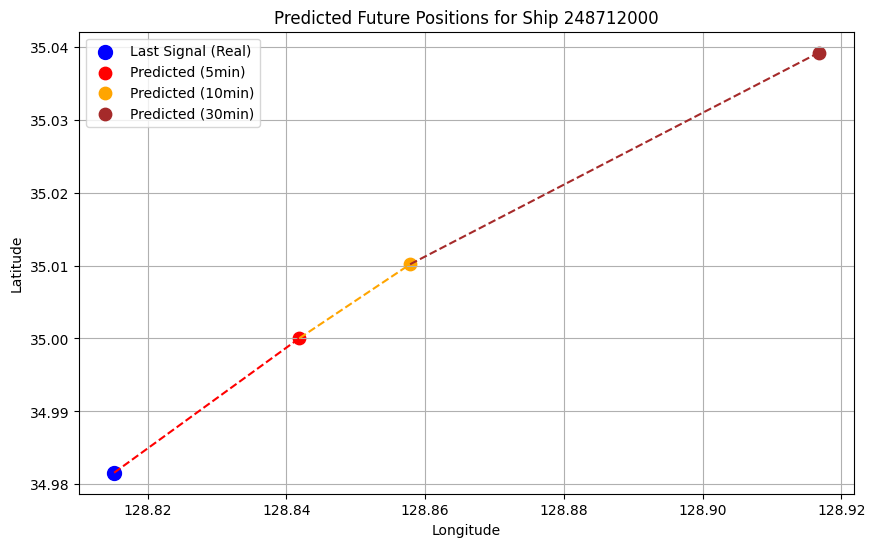

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ 특정 선박 선택 (예: ship_index = 4)
ship_index = 18  # 원하는 MMSI의 인덱스로 변경 가능

# ✅ MMSI 가져오기
mmsi = comparison.loc[ship_index, "MMSI"]

# ✅ 해당 MMSI의 마지막 신호 가져오기
last_signal = data[data["mmsi"] == mmsi].iloc[-1]  # 해당 MMSI의 마지막 행 선택

# ✅ 🚀 (1) 로그 변환 해제 (`log1p()` 적용 해제)
last_lat_lon_logged = np.array([[last_signal["lat"], last_signal["lon"]]])  # 2D 배열 변환
last_lat_lon_exp = np.expm1(last_lat_lon_logged)  # ✅ 로그 변환 해제

# ✅ 🚀 (2) MinMaxScaler 역변환 적용 (MinMaxScaler 해제)
last_lat_lon_original = scaler.inverse_transform(last_lat_lon_exp)  # ✅ MinMaxScaler 해제

# ✅ 최종 위경도 값 할당
last_lat = last_lat_lon_original[0, 0]
last_lon = last_lat_lon_original[0, 1]

# ✅ 예측 좌표 (5분 후, 10분 후, 30분 후)
pred_lat_5min = comparison.loc[ship_index, 'Pred Lat @ 5min']
pred_lon_5min = comparison.loc[ship_index, 'Pred Lon @ 5min']

pred_lat_10min = comparison.loc[ship_index, 'Pred Lat @ 10min']
pred_lon_10min = comparison.loc[ship_index, 'Pred Lon @ 10min']

pred_lat_30min = comparison.loc[ship_index, 'Pred Lat @ 30min']
pred_lon_30min = comparison.loc[ship_index, 'Pred Lon @ 30min']

# ✅ 그래프 생성
plt.figure(figsize=(10, 6))

# ✅ 실제 마지막 신호 (파란색)
plt.scatter(last_lon, last_lat, label='Last Signal (Real)', c='blue', s=100, marker='o')

# ✅ 5분 후 예측 (빨간색)
plt.scatter(pred_lon_5min, pred_lat_5min, label='Predicted (5step)', c='red', s=80, marker='o')
plt.plot([last_lon, pred_lon_5min], [last_lat, pred_lat_5min], c='red', linestyle='dashed', linewidth=1.5)

# ✅ 10분 후 예측 (주황색)
plt.scatter(pred_lon_10min, pred_lat_10min, label='Predicted (10step)', c='orange', s=80, marker='o')
plt.plot([pred_lon_5min, pred_lon_10min], [pred_lat_5min, pred_lat_10min], c='orange', linestyle='dashed', linewidth=1.5)

# ✅ 30분 후 예측 (갈색)
plt.scatter(pred_lon_30min, pred_lat_30min, label='Predicted (30step)', c='brown', s=80, marker='o')
plt.plot([pred_lon_10min, pred_lon_30min], [pred_lat_10min, pred_lat_30min], c='brown', linestyle='dashed', linewidth=1.5)

# ✅ 그래프 설정
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Predicted Future Positions for Ship {mmsi}')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# ✅ 특정 선박 선택 (예: 첫 번째 선박)
ship_index = 0  # 원하는 MMSI의 인덱스 변경 가능

# ✅ 마지막 좌표 (실제 마지막 신호)
last_lat = X_last_all[ship_index][-1, 0]  # 마지막 입력 데이터의 위도
last_lon = X_last_all[ship_index][-1, 1]  # 마지막 입력 데이터의 경도

# ✅ 예측 좌표 (5분 후, 10분 후, 30분 후)
pred_lat_5min = comparison.loc[ship_index, 'Pred Lat @ 5min']
pred_lon_5min = comparison.loc[ship_index, 'Pred Lon @ 5min']

pred_lat_10min = comparison.loc[ship_index, 'Pred Lat @ 10min']
pred_lon_10min = comparison.loc[ship_index, 'Pred Lon @ 10min']

pred_lat_30min = comparison.loc[ship_index, 'Pred Lat @ 30min']
pred_lon_30min = comparison.loc[ship_index, 'Pred Lon @ 30min']

plt.figure(figsize=(10, 6))

# ✅ 마지막 신호 위치 (파란색)
plt.scatter(last_lon, last_lat, label='Last Position', c='blue', s=80, marker='o')

# ✅ 5분 후 예측 (빨간색)
plt.scatter(pred_lon_5min, pred_lat_5min, label='Predicted (5min)', c='red', s=50, marker='o')
plt.plot([last_lon, pred_lon_5min], [last_lat, pred_lat_5min], c='red', linestyle='dashed', linewidth=1)

# ✅ 10분 후 예측 (주황색)
plt.scatter(pred_lon_10min, pred_lat_10min, label='Predicted (10min)', c='orange', s=50, marker='o')
plt.plot([pred_lon_5min, pred_lon_10min], [pred_lat_5min, pred_lat_10min], c='orange', linestyle='dashed', linewidth=1)

# ✅ 30분 후 예측 (갈색)
plt.scatter(pred_lon_30min, pred_lat_30min, label='Predicted (30min)', c='brown', s=50, marker='o')
plt.plot([pred_lon_10min, pred_lon_30min], [pred_lat_10min, pred_lat_30min], c='brown', linestyle='dashed', linewidth=1)

# ✅ 그래프 설정
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Predicted Future Positions for Ship {comparison.loc[ship_index, "MMSI"]}')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# ✅ 특정 선박 선택 (예: 첫 번째 선박)
ship_index = 0  # 원하는 MMSI의 인덱스 변경 가능

# ✅ 과거 항로 (X_last_all에서 이전 데이터 추출)
past_lats = X_last_all[ship_index][:, 0]  # 과거 위도
past_lons = X_last_all[ship_index][:, 1]  # 과거 경도

# ✅ 마지막 신호 (실제 마지막 데이터)
last_lat = past_lats[-1]  # 마지막 입력 데이터의 위도
last_lon = past_lons[-1]  # 마지막 입력 데이터의 경도

# ✅ 예측 좌표 (5분 후, 10분 후, 30분 후)
pred_lat_5min = comparison.loc[ship_index, 'Pred Lat @ 5min']
pred_lon_5min = comparison.loc[ship_index, 'Pred Lon @ 5min']

pred_lat_10min = comparison.loc[ship_index, 'Pred Lat @ 10min']
pred_lon_10min = comparison.loc[ship_index, 'Pred Lon @ 10min']

pred_lat_30min = comparison.loc[ship_index, 'Pred Lat @ 30min']
pred_lon_30min = comparison.loc[ship_index, 'Pred Lon @ 30min']

plt.figure(figsize=(10, 6))

# ✅ 과거 항로 (검은색 점선)
plt.plot(past_lons, past_lats, linestyle='dotted', color='black', linewidth=1, label="Past Path")
plt.scatter(past_lons, past_lats, c='black', s=20)  # 과거 위치들

# ✅ 마지막 신호 위치 (파란색)
plt.scatter(last_lon, last_lat, label='Last Position', c='blue', s=80, marker='o')

# ✅ 5분 후 예측 (빨간색)
plt.scatter(pred_lon_5min, pred_lat_5min, label='Predicted (5min)', c='red', s=50, marker='o')
plt.plot([last_lon, pred_lon_5min], [last_lat, pred_lat_5min], c='red', linestyle='dashed', linewidth=1)

# ✅ 10분 후 예측 (주황색)
plt.scatter(pred_lon_10min, pred_lat_10min, label='Predicted (10min)', c='orange', s=50, marker='o')
plt.plot([pred_lon_5min, pred_lon_10min], [pred_lat_5min, pred_lat_10min], c='orange', linestyle='dashed', linewidth=1)

# ✅ 30분 후 예측 (갈색)
plt.scatter(pred_lon_30min, pred_lat_30min, label='Predicted (30min)', c='brown', s=50, marker='o')
plt.plot([pred_lon_10min, pred_lon_30min], [pred_lat_10min, pred_lat_30min], c='brown', linestyle='dashed', linewidth=1)

# ✅ 그래프 설정
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Past & Predicted Future Positions for Ship {comparison.loc[ship_index, "MMSI"]}')
plt.legend()
plt.show()


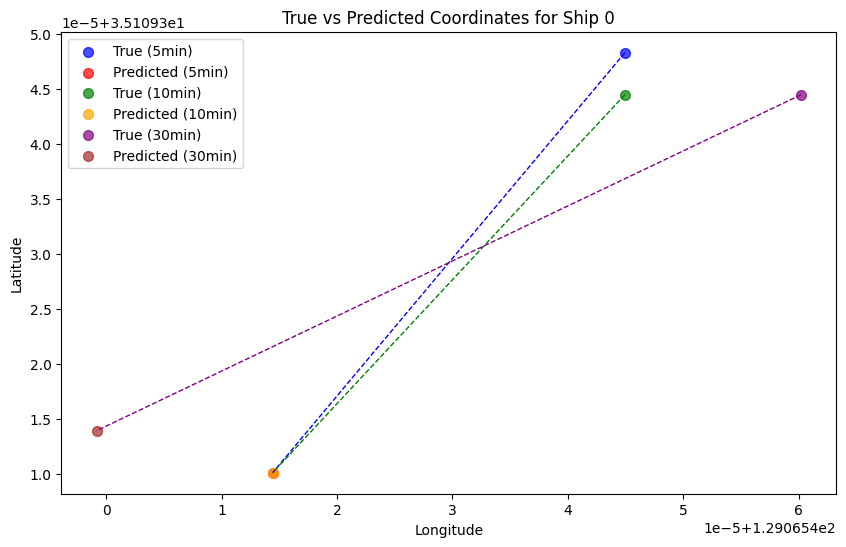

In [ ]:
import matplotlib.pyplot as plt

# 특정 선박의 인덱스를 선택 (예: 첫 번째 선박 데이터)
ship_index = 0  # 원하는 선박의 인덱스로 변경 가능

plt.figure(figsize=(10, 6))

# ✅ 5분 후
plt.scatter(comparison.loc[ship_index, 'True Lon (5min)'], comparison.loc[ship_index, 'True Lat (5min)'],
            label='True (5min)', alpha=0.7, c='blue', s=50)
plt.scatter(comparison.loc[ship_index, 'Predicted Lon (5min)'], comparison.loc[ship_index, 'Predicted Lat (5min)'],
            label='Predicted (5min)', alpha=0.7, c='red', s=50)
plt.plot([comparison.loc[ship_index, 'True Lon (5min)'], comparison.loc[ship_index, 'Predicted Lon (5min)']],
         [comparison.loc[ship_index, 'True Lat (5min)'], comparison.loc[ship_index, 'Predicted Lat (5min)']],
         c='blue', linestyle='dashed', linewidth=1)  # 선 추가

# ✅ 10분 후
plt.scatter(comparison.loc[ship_index, 'True Lon (10min)'], comparison.loc[ship_index, 'True Lat (10min)'],
            label='True (10min)', alpha=0.7, c='green', s=50)
plt.scatter(comparison.loc[ship_index, 'Predicted Lon (10min)'], comparison.loc[ship_index, 'Predicted Lat (10min)'],
            label='Predicted (10min)', alpha=0.7, c='orange', s=50)
plt.plot([comparison.loc[ship_index, 'True Lon (10min)'], comparison.loc[ship_index, 'Predicted Lon (10min)']],
         [comparison.loc[ship_index, 'True Lat (10min)'], comparison.loc[ship_index, 'Predicted Lat (10min)']],
         c='green', linestyle='dashed', linewidth=1)  # 선 추가

# ✅ 30분 후
plt.scatter(comparison.loc[ship_index, 'True Lon (30min)'], comparison.loc[ship_index, 'True Lat (30min)'],
            label='True (30min)', alpha=0.7, c='purple', s=50)
plt.scatter(comparison.loc[ship_index, 'Predicted Lon (30min)'], comparison.loc[ship_index, 'Predicted Lat (30min)'],
            label='Predicted (30min)', alpha=0.7, c='brown', s=50)
plt.plot([comparison.loc[ship_index, 'True Lon (30min)'], comparison.loc[ship_index, 'Predicted Lon (30min)']],
         [comparison.loc[ship_index, 'True Lat (30min)'], comparison.loc[ship_index, 'Predicted Lat (30min)']],
         c='purple', linestyle='dashed', linewidth=1)  # 선 추가

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'True vs Predicted Coordinates for Ship {ship_index}')
plt.legend()
plt.show()


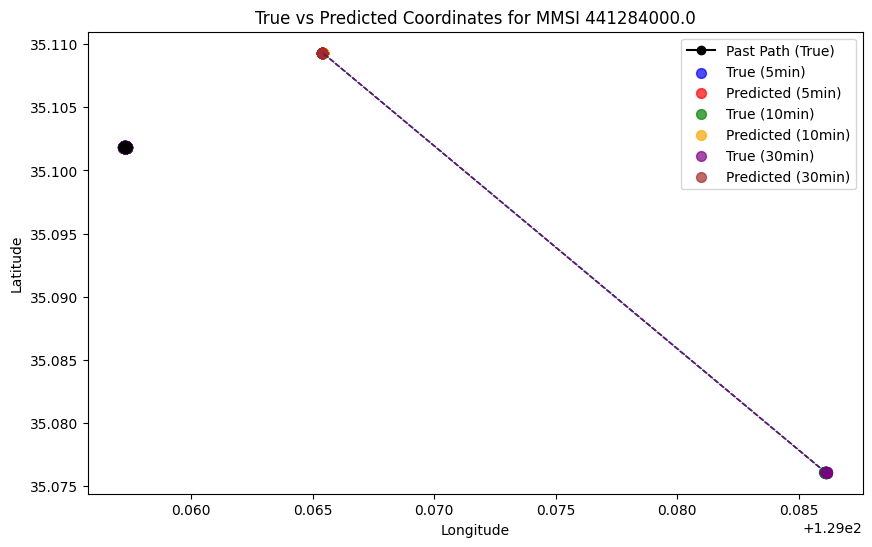

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ✅ 컬럼명을 모두 소문자로 변환 (대소문자 문제 해결)
data.columns = data.columns.str.lower()
comparison.columns = comparison.columns.str.lower()

# ✅ MMSI 컬럼 존재 여부 확인 및 추가
if "mmsi" not in comparison.columns:
    print("⚠ Warning: 'mmsi' 컬럼이 comparison 데이터프레임에 없음. MMSI 추가 중...")
    if "mmsi" in data.columns:
        comparison["mmsi"] = data.iloc[-len(comparison):]["mmsi"].values  # MMSI 추가
    else:
        print("⚠ Warning: 'mmsi' 컬럼이 원본 데이터에도 없습니다. 임시 MMSI 생성")
        comparison["mmsi"] = np.arange(len(comparison))  # 임시 ID 부여

# ✅ 특정 MMSI 선택 (첫 번째 선박의 MMSI 가져오기)
ship_index = 0
target_mmsi = comparison.iloc[ship_index]["mmsi"]  # "mmsi" 소문자로 변경

# ✅ MMSI를 사용하여 원본 데이터에서 특정 선박의 과거 이동 경로 가져오기
past_data = data[data["mmsi"] == target_mmsi].copy()
past_data = past_data.sort_values(by="created_at")  # 시간순 정렬

# ✅ 역스케일링 함수 정의 (과거 이동 경로만 변환)
def inverse_transform_lat_lon(scaled_data, scaler):
    """
    로그 변환 해제 후 MinMaxScaler 역변환 수행
    """
    exp_data = np.expm1(scaled_data)  # 로그 변환 해제
    return scaler.inverse_transform(exp_data)  # MinMaxScaler 역변환

# ✅ 과거 이동 경로 데이터만 역스케일링 적용 (예측 좌표는 건드리지 않음)
past_data[["lat", "lon"]] = inverse_transform_lat_lon(past_data[["lat", "lon"]].values, scaler)

# ✅ 예측 데이터에서 해당 MMSI의 데이터 가져오기 (예측된 좌표는 변환하지 않음)
ship_prediction = comparison[comparison["mmsi"] == target_mmsi].copy()

# ✅ 과거 이동 경로 시각화
plt.figure(figsize=(10, 6))

# ✅ 과거 이동 경로 (실제 기록) - 역스케일링된 좌표 사용
plt.plot(past_data["lon"], past_data["lat"], linestyle='solid', color='black', marker='o', label="Past Path (True)")

# ✅ 5분 후 예측 및 실제값 시각화 (예측 좌표는 변환 X)
plt.scatter(ship_prediction["true lon (5min)"], ship_prediction["true lat (5min)"], 
            label="True (5min)", alpha=0.7, c="blue", s=50)
plt.scatter(ship_prediction["predicted lon (5min)"], ship_prediction["predicted lat (5min)"], 
            label="Predicted (5min)", alpha=0.7, c="red", s=50)
plt.plot([ship_prediction["true lon (5min)"].values[0], ship_prediction["predicted lon (5min)"].values[0]],
         [ship_prediction["true lat (5min)"].values[0], ship_prediction["predicted lat (5min)"].values[0]],
         c="blue", linestyle="dashed", linewidth=1)

# ✅ 10분 후 예측 및 실제값 시각화
plt.scatter(ship_prediction["true lon (10min)"], ship_prediction["true lat (10min)"], 
            label="True (10min)", alpha=0.7, c="green", s=50)
plt.scatter(ship_prediction["predicted lon (10min)"], ship_prediction["predicted lat (10min)"], 
            label="Predicted (10min)", alpha=0.7, c="orange", s=50)
plt.plot([ship_prediction["true lon (10min)"].values[0], ship_prediction["predicted lon (10min)"].values[0]],
         [ship_prediction["true lat (10min)"].values[0], ship_prediction["predicted lat (10min)"].values[0]],
         c="green", linestyle="dashed", linewidth=1)

# ✅ 30분 후 예측 및 실제값 시각화
plt.scatter(ship_prediction["true lon (30min)"], ship_prediction["true lat (30min)"], 
            label="True (30min)", alpha=0.7, c="purple", s=50)
plt.scatter(ship_prediction["predicted lon (30min)"], ship_prediction["predicted lat (30min)"], 
            label="Predicted (30min)", alpha=0.7, c="brown", s=50)
plt.plot([ship_prediction["true lon (30min)"].values[0], ship_prediction["predicted lon (30min)"].values[0]],
         [ship_prediction["true lat (30min)"].values[0], ship_prediction["predicted lat (30min)"].values[0]],
         c="purple", linestyle="dashed", linewidth=1)

# ✅ 그래프 스타일 설정
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"True vs Predicted Coordinates for MMSI {target_mmsi}")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ✅ 컬럼명을 모두 소문자로 변환 (대소문자 문제 해결)
data.columns = data.columns.str.lower()
comparison.columns = comparison.columns.str.lower()

# ✅ MMSI 컬럼 존재 여부 확인 및 추가
if "mmsi" not in comparison.columns:
    print("⚠ Warning: 'mmsi' 컬럼이 comparison 데이터프레임에 없음. MMSI 추가 중...")
    if "mmsi" in data.columns:
        comparison["mmsi"] = data.iloc[-len(comparison):]["mmsi"].values  # MMSI 추가
    else:
        print("⚠ Warning: 'mmsi' 컬럼이 원본 데이터에도 없습니다. 임시 MMSI 생성")
        comparison["mmsi"] = np.arange(len(comparison))  # 임시 ID 부여


# ✅ 특정 MMSI 직접 입력 (예: 123456789)
target_mmsi = 440126950  # 원하는 MMSI 값을 입력하세요.

# ✅ 해당 MMSI가 comparison에 존재하는지 확인
if target_mmsi not in comparison["mmsi"].values:
    raise ValueError(f"❌ 입력한 MMSI {target_mmsi}가 comparison 데이터프레임에 존재하지 않습니다.")

# ✅ MMSI를 사용하여 원본 데이터에서 특정 선박의 과거 이동 경로 가져오기
past_data = data[data["mmsi"] == target_mmsi].copy()
past_data = past_data.sort_values(by="created_at")  # 시간순 정렬

# ✅ MMSI를 사용하여 예측 데이터에서 특정 선박의 예측 값 가져오기
ship_prediction = comparison[comparison["mmsi"] == target_mmsi].copy()


# ✅ MMSI를 사용하여 원본 데이터에서 특정 선박의 과거 이동 경로 가져오기
past_data = data[data["mmsi"] == target_mmsi].copy()
past_data = past_data.sort_values(by="created_at")  # 시간순 정렬

# ✅ 예측 데이터에서 해당 MMSI의 데이터 가져오기
ship_prediction = comparison[comparison["mmsi"] == target_mmsi].copy()

# ✅ 과거 이동 경로 시각화
plt.figure(figsize=(10, 6))

# ✅ 과거 이동 경로 (실제 기록)
plt.plot(past_data["lon"], past_data["lat"], linestyle='solid', color='black', marker='o', label="Past Path (True)")

# ✅ 5분 후 예측 및 실제값 시각화
plt.scatter(ship_prediction["true lon (5min)"], ship_prediction["true lat (5min)"], 
            label="True (5min)", alpha=0.7, c="blue", s=50)
plt.scatter(ship_prediction["predicted lon (5min)"], ship_prediction["predicted lat (5min)"], 
            label="Predicted (5min)", alpha=0.7, c="red", s=50)
plt.plot([ship_prediction["true lon (5min)"].values[0], ship_prediction["predicted lon (5min)"].values[0]],
         [ship_prediction["true lat (5min)"].values[0], ship_prediction["predicted lat (5min)"].values[0]],
         c="blue", linestyle="dashed", linewidth=1)

# ✅ 10분 후 예측 및 실제값 시각화
plt.scatter(ship_prediction["true lon (10min)"], ship_prediction["true lat (10min)"], 
            label="True (10min)", alpha=0.7, c="green", s=50)
plt.scatter(ship_prediction["predicted lon (10min)"], ship_prediction["predicted lat (10min)"], 
            label="Predicted (10min)", alpha=0.7, c="orange", s=50)
plt.plot([ship_prediction["true lon (10min)"].values[0], ship_prediction["predicted lon (10min)"].values[0]],
         [ship_prediction["true lat (10min)"].values[0], ship_prediction["predicted lat (10min)"].values[0]],
         c="green", linestyle="dashed", linewidth=1)

# ✅ 30분 후 예측 및 실제값 시각화
plt.scatter(ship_prediction["true lon (30min)"], ship_prediction["true lat (30min)"], 
            label="True (30min)", alpha=0.7, c="purple", s=50)
plt.scatter(ship_prediction["predicted lon (30min)"], ship_prediction["predicted lat (30min)"], 
            label="Predicted (30min)", alpha=0.7, c="brown", s=50)
plt.plot([ship_prediction["true lon (30min)"].values[0], ship_prediction["predicted lon (30min)"].values[0]],
         [ship_prediction["true lat (30min)"].values[0], ship_prediction["predicted lat (30min)"].values[0]],
         c="purple", linestyle="dashed", linewidth=1)

# ✅ 그래프 스타일 설정
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"True vs Predicted Coordinates for MMSI {target_mmsi}")
plt.legend()
plt.show()


ValueError: ❌ 입력한 MMSI 440126950가 comparison 데이터프레임에 존재하지 않습니다.